# Modeling Procedure 

In principle, the neural network could be defined by graphs consist of tensors and trained through automatic differenciate.

However, for simplification, we recommend to use high-level Keras API in Tensorflow to implement the neural networks.

The common procedures of implementing neural networks using TensorFlow are:

1. Data preparation and loading
2. Model definition
3. Model training
4. Model evaluation, application and saving

In [9]:
import sys
import os
project_path = os.path.abspath(os.path.join(os.getcwd(), "../.."))
sys.path.append(project_path)
import numpy as np
import pandas as pd
import datetime

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import models,layers

from utils.dataset_loader import load_cifar10,structured_data_preprocessing,get_dataset_from_list_files
from utils.trainer import plot_metric
from backbone.cnn import CNN_3L, Sequential_CNN_3L

In [10]:
# 1 Dataset and dataloader
train_path = "../../data/cifar2/train/*/*.jpg"
test_path = "../../data/cifar2/test/*/*.jpg"
ds_train, ds_test = get_dataset_from_list_files(train_path,test_path, BATCH_SIZE=100)
# print(f"x_train.shape = { x_train.shape} x_test.shape = {x_test.shape}" )
for x,y in ds_train.take(1): # ds_train = (x_train , y_train)
    print(x.shape,y.shape)

# 2 Model definition (Sequential, Model(Input,Output))
tf.keras.backend.clear_session()
inputs = layers.Input(shape=(32,32,3))
x = layers.Conv2D(32,kernel_size=(3,3))(inputs)
x = layers.MaxPool2D()(x)
x = layers.Conv2D(64,kernel_size=(5,5))(x)
x = layers.MaxPool2D()(x)
x = layers.Dropout(rate=0.1)(x)
x = layers.Flatten()(x)
x = layers.Dense(32,activation='relu')(x)
outputs = layers.Dense(1,activation = 'sigmoid')(x)

model = models.Model(inputs = inputs,outputs = outputs)

# 3 Set optimizer and training
model.compile(optimizer="SGD", loss='binary_crossentropy',
            metrics=['accuracy'])

stamp = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
logdir = os.path.join('../../data', 'autograph', stamp)
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)
history = model.fit(ds_train, epochs=10,
                    validation_data=ds_test, # Could just use y_test instead of validation_split=0.2,
                    callbacks = [tensorboard_callback],workers = 4)  
model.summary()

# 4 Model evaluation, application and saving

(100, 32, 32, 3) (100,)
Epoch 1/10
  1/100 [..............................] - ETA: 0s - loss: 0.6879 - accuracy: 0.5300WARNING:tensorflow:From /rds/user/hpczeji1/hpc-work/anaconda3/envs/py36/lib/python3.6/site-packages/tensorflow/python/ops/summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
100/100 [==============================] - 4s 42ms/step - loss: 0.6394 - accuracy: 0.6435 - val_loss: 0.5732 - val_accuracy: 0.7270
Epoch 2/10
100/100 [==============================] - 2s 18ms/step - loss: 0.5385 - accuracy: 0.7540 - val_loss: 0.4731 - val_accuracy: 0.7950
Epoch 3/10
100/100 [==============================] - 2s 16ms/step - loss: 0.4863 - accuracy: 0.7775 - val_loss: 0.4339 - val_accuracy: 0.8115
Epoch 4/10
100/100 [==============================] - 2s 16ms/step - loss: 0.4725 - accuracy: 0.7839 - val_loss: 0.4167 - val_accuracy: 0.8225
Epoch

In [16]:
## 4.1 Model evaluate 
model.evaluate(ds_test)  # Val_loss,val_accuracy， input ds_test instead of x = x_test,y = y_test

## 4.2 Model application
model.predict(ds_test)  # Predict the possiblities
for x,y in ds_test.take(1):
    print(model.predict_on_batch(x[0:20]))


20/20 [==============================] - 0s 6ms/step - loss: 0.3517 - accuracy: 0.8520
[[0.8667978 ]
 [0.90864885]
 [0.29142696]
 [0.0053263 ]
 [0.11569688]
 [0.0111368 ]
 [0.0021446 ]
 [0.9541129 ]
 [0.5680897 ]
 [0.07136855]
 [0.24556926]
 [0.8283427 ]
 [0.47568238]
 [0.00329617]
 [0.11916035]
 [0.6746347 ]
 [0.2022931 ]
 [0.5823696 ]
 [0.84328985]
 [0.90692556]]


In [17]:
## 4.3 Model saving
model.save('../../model_saved/image_data_keras_model.model') 
del model  #Deleting current model
model = models.load_model('../../model_saved/image_data_keras_model.model')

# Could also model.to_json/models.model_from_json to save structure
# Could also model.save_weights, and save ckpt in save_format = "tf"

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: ../../model_saved/image_data_keras_model.model/assets


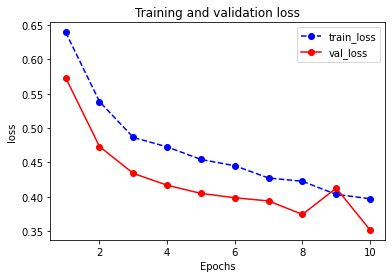

In [18]:
# 4 Model evaluation, application and saving
plot_metric(history,"loss")

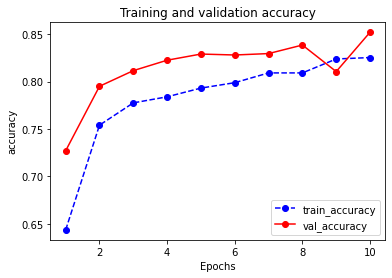

In [20]:
plot_metric(history,"accuracy")

In [21]:
%load_ext tensorboard
#%tensorboard --logdir ../data/keras_model
from tensorboard import notebook
notebook.list() 

Known TensorBoard instances:
  - port 6006: logdir logs/ (started 18:29:25 ago; pid 14898)
  - port 6006: logdir logs/ (started 1 day, 20:30:25 ago; pid 16979)


In [25]:
#Checking model in tensorboard
notebook.start("--logdir ../../data/keras_model")

In [24]:
dfhistory = pd.DataFrame(history.history)
dfhistory.index = range(1,len(dfhistory) + 1)
dfhistory.index.name = 'epoch'

dfhistory

,loss,accuracy,val_loss,val_accuracy
epoch,,,,
1,0.639394,0.6435,0.573228,0.7270
2,0.538479,0.7540,0.473066,0.7950
3,0.486308,0.7775,0.433942,0.8115
4,0.472539,0.7839,0.416745,0.8225
5,0.454203,0.7931,0.404838,0.8290
6,0.445130,0.7988,0.398460,0.8280
7,0.427248,0.8091,0.393846,0.8295
8,0.422462,0.8091,0.374201,0.8385
9,0.403383,0.8238,0.412471,0.8105
